# **NLP Notebook - HW2 (2021)**
### *Andrea Trianni  - 1806198*
---
This notebook covers the entire machine learning pipeline for the HW2 of the NLP course. The topic is Aspect Based Sentiment Analysis

Into this notebook i will make a strong use of the classes and code defined into /hw2/stud folder, designed by me. 

Information and documentation about that can be founded into *.py code files.

During this notebook, i will first visualize and process the data (step by step), train my own models, and collect the results. Other information will be provided during the notebook chapters.

The best weights will be used and re-loaded from disk to predict the labels of the test dataset.


## 0. First steps

Into this section i will do preliminaries operations:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Notebook has the permission to automatically mount the drive, now i move th cwd to the project folfer

%cd /content/drive/MyDrive/nlp2021-hw2-master/hw2

/content/drive/MyDrive/nlp2021-hw2-master/hw2


In [3]:
# Install external libraries

! pip install pytorch-lightning
! pip install transformers


# Check cuda support and gpu type

! nvidia-smi

     |████████████████████████████████| 919 kB 13.1 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
     |████████████████████████████████| 282 kB 50.0 MB/s 
     |████████████████████████████████| 829 kB 43.2 MB/s 
     |████████████████████████████████| 119 kB 46.5 MB/s 
     |████████████████████████████████| 1.3 MB 46.0 MB/s 
     |████████████████████████████████| 294 kB 51.3 MB/s 
     |████████████████████████████████| 142 kB 52.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=ac471ee1ba2f849f96c7c4c831b5961b45a9eb8a94c424159990267a7b4245dd
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-

In [4]:
# Import needed libraries 

import numpy as np
import math
from math import pi, sqrt, exp
from collections import defaultdict, Counter, OrderedDict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

In [5]:
# Import code-base from stud folder

from stud.Utils import *
from stud.Dataset import *
from stud.Classifiers import *

404 Client Error: Not Found for url: https://huggingface.co/./model/pre_trained/resolve/main/config.json


## 1. Data Visualization

Into this section i will visualize the data and collect interesting plots that will be added into the PDF report.


In [6]:
# Declaring path of datasets

rest_train_path = "../data/restaurants_train.json"
rest_val_path = "../data/restaurants_dev.json"

laptop_train_path = "../data/laptops_train.json"
laptop_val_path = "../data/laptops_dev.json"

pretrained_path = "../model/pre_trained"

{'rest': 2500, 'laptop': 2500}
{'rest': 541, 'laptop': 545}


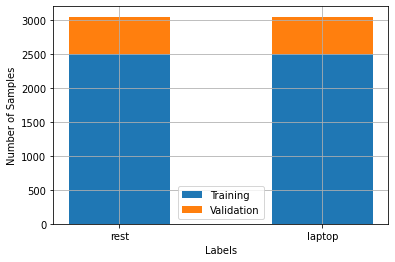

In [ ]:
# Plot General: datasets sizes

laptop_train = TextDataset.from_disk(laptop_train_path, task = "a")
rest_train   = TextDataset.from_disk(rest_train_path, task = "a")

laptop_val = TextDataset.from_disk(laptop_val_path, task = "a")
rest_val   = TextDataset.from_disk(rest_val_path, task = "a")

train_counts = {'rest':len(rest_train), 'laptop':len(laptop_train)}
val_counts   = {'rest':len(rest_val), 'laptop':len(laptop_val)}
print(train_counts)
print(val_counts)

fig = plt.figure(); ax = plt.axes()
ax.bar(["rest","laptop"], [train_counts["rest"],train_counts["laptop"]], width=0.5, label="Training")
ax.bar(["rest","laptop"], [val_counts["rest"],val_counts["laptop"]], bottom=[train_counts["rest"],train_counts["laptop"]],  width=0.5, label="Validation")

plt.ylabel("Number of Samples"); 
plt.xlabel("Labels")
ax.legend()
plt.grid()
plt.show()

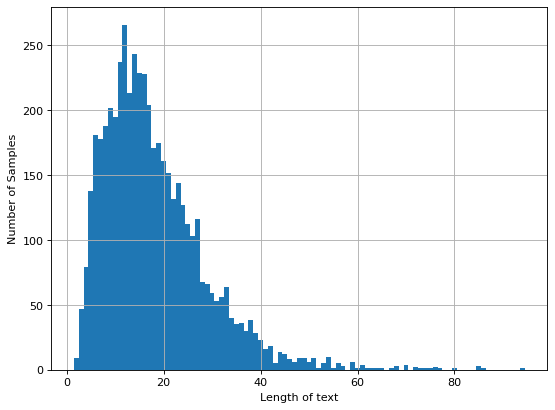

In [ ]:
# Plot General: review text length

dataset = laptop_train.merge(rest_train )

lengths = OrderedDict()

for sample in dataset:
  token = tokenizer(sample['text'], add_special_tokens=False)['input_ids']
  lengths[len(token)] = lengths.get(len(token), 0) + 1

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()
ax.bar(lengths.keys(), lengths.values(), width=1)

plt.ylabel("Number of Samples")
plt.xlabel("Length of text")
plt.grid()
plt.show()

Counter({1: 3517, 2: 1051, 3: 263, 4: 80, 5: 27, 6: 9, 9: 3, 7: 2, 13: 2, 19: 1, 15: 1, 10: 1})


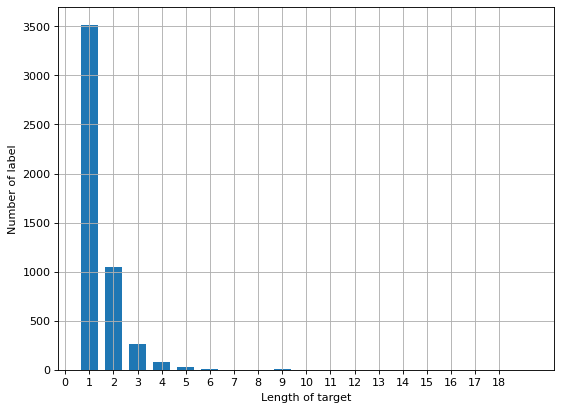

In [ ]:
# Plot task A:  target length distribution 

lengths= []
for sample in dataset:
  lengths += [ len(x[1].split(" ")) for x in sample['targets']]

lengths = Counter(lengths)
print(lengths)

index = [i for i in range(0,max(lengths.keys()))]
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()
plt.xticks(index,index)
ax.bar(lengths.keys(), lengths.values(), width=0.7)

plt.ylabel("Number of label"); 
plt.xlabel("Length of target")
plt.grid()
plt.show()

Counter({'food': 292, 'service': 172, 'price': 81, 'prices': 56, 'place': 54, 'dinner': 48, 'screen': 48, 'staff': 45, 'use': 44, 'menu': 43, 'battery life': 42, 'atmosphere': 39, 'battery': 38, 'pizza': 38, 'keyboard': 37, 'meal': 32, 'table': 32, 'sushi': 31, 'bar': 30, 'quality': 28, 'warranty': 25, 'Service': 25, 'features': 25, 'portions': 25, 'software': 25, 'drinks': 24, 'dishes': 23, 'hard drive': 22, 'lunch': 22, 'wine': 22, 'waiter': 22, 'programs': 21, 'size': 20, 'speed': 19, 'wait': 19, 'performance': 19, 'Food': 17, 'decor': 17, 'dish': 17, 'fish': 17, 'Windows': 17, 'ambience': 16, 'value': 15, 'motherboard': 15, 'reservation': 14, 'ambiance': 14, 'priced': 14, 'dessert': 14, 'applications': 14, 'rice': 14, 'waitress': 13, 'graphics': 13, 'bagels': 13, 'served': 13, 'charge': 12, 'bill': 12, 'runs': 12, 'wine list': 12, 'tables': 12, 'works': 12, 'cost': 12, 'music': 12, 'program': 12, 'Vista': 12, 'design': 12, 'gaming': 11, 'owner': 11, 'space': 11, 'system': 11, 'appe

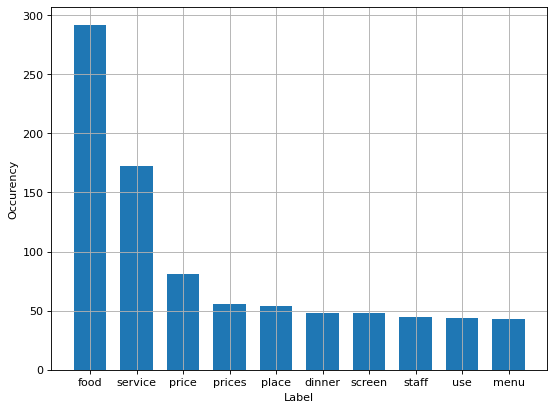

In [ ]:
# Plot task A:  most popoular targets

labels= []
for sample in dataset:
  labels += [ x[1] for x in sample['targets']]

labels  = Counter(labels)
print(labels)

words  = [w for w,c in labels.most_common(10) ]
counts = [c for w,c in labels.most_common(10) ]


index = np.arange(10)
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()
plt.bar(index, counts, 0.7)
plt.xticks(index, words)

plt.ylabel("Occurency"); 
plt.xlabel("Label")
plt.grid()
plt.show()

Counter({'positive': 2605, 'negative': 1364, 'neutral': 877, 'conflict': 111})


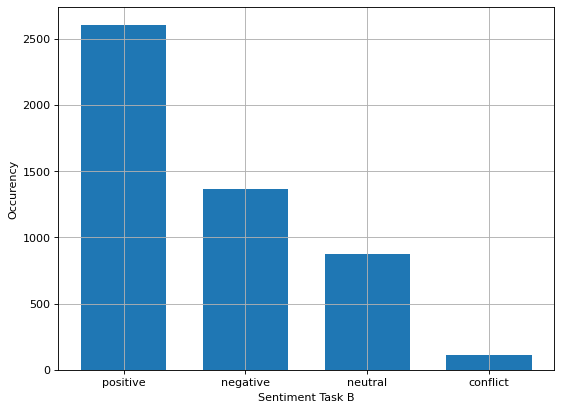

In [ ]:
# Plot task B: Sentiment polarity distribution

sent = []
for sample in dataset:
  sent += [ x[2] for x in sample['targets']]

sent = Counter(sent)
print(sent)

words  = [w for w,c in sent.most_common() ]
counts = [c for w,c in sent.most_common() ]

index = np.arange(4)
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()
plt.bar(index, counts, 0.7)
plt.xticks(index, words)

plt.ylabel("Occurency"); 
plt.xlabel("Sentiment Task B")
plt.grid()
plt.show()

Counter({'food': 1008, 'anecdotes/miscellaneous': 941, 'service': 478, 'ambience': 355, 'price': 268})


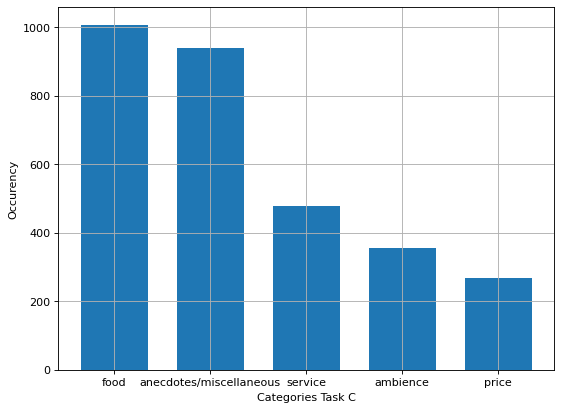

In [ ]:
# Plot task C: Category label distribution

dataset = TextDataset.from_disk(rest_train_path, task = "c")

cat = []
for sample in dataset:
  cat += [ x[0] for x in sample['categories']]

cat = Counter(cat)
print(cat)

words  = [w for w,c in cat.most_common() ]
counts = [c for w,c in cat.most_common() ]

index = np.arange(5)
fig = plt.figure(figsize=(8, 6), dpi=80)
plt.bar(index, counts, 0.7)
plt.xticks(index, words)

plt.ylabel("Occurency")
plt.xlabel("Categories Task C")
plt.grid()
plt.show()

Counter({'positive': 2674, 'negative': 944, 'neutral': 477, 'conflict': 221})


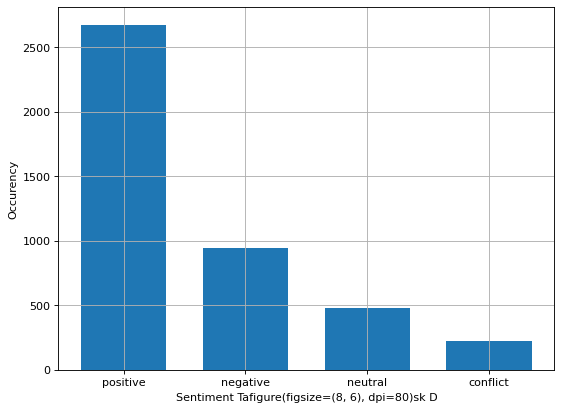

In [ ]:
# Plot task D: Sentiment polarity distribution

dataset = TextDataset.from_disk(rest_train_path, task = "d")

sent = []
for sample in dataset:
  sent += [ x[1] for x in sample['categories']]

sent = Counter(sent)
print(sent)

words  = [w for w,c in sent.most_common() ]
counts = [c for w,c in sent.most_common() ]

index = np.arange(4)
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes()
plt.bar(index, counts, 0.7)
plt.xticks(index, words)

plt.ylabel("Occurency"); 
plt.xlabel("Sentiment Tafigure(figsize=(8, 6), dpi=80)sk D")
plt.grid()
plt.show()

## 2. Data Processing Pipeline

In this section i am going to download vocabulary and pretrained model from internet and store the files locally. Model includes also the tokenizer that take care of encoding process. 

This phase of vectorizing is mainly performed in the codebase: *Utils.py, Dataset.py*

In [ ]:
# Download and store pretrained tokenizer, vocabularies, and models

'''
from transformers import BertModel,AutoTokenizer

model = BertModel.from_pretrained('bert-base-cased')
model.save_pretrained('./model/pre_trained')
model = BertModel.from_pretrained('./model/pre_trained')

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
tokenizer.save_pretrained('./model/pre_trained')
tokenizer= AutoTokenizer.from_pretrained('./model/pre_trained')
'''

In [7]:
# Calculating class weights


# TASK E2E

laptop_train = TextDataset.from_disk(laptop_train_path, task = "a")
rest_train   = TextDataset.from_disk(rest_train_path, task = "a")
dataset = laptop_train.merge(rest_train )

iob = []
for sample in dataset:
  iob += [ x.item()  for x in sample['aspect_label_e2e'] if x.item()!= 0  ]

class_weights = class_weight.compute_class_weight('balanced',[1,2,3,4,5,6],iob)
w_e2e = torch.Tensor([0]+ [math.sqrt(x) for x in class_weights ] )
print(w_e2e)


# TASK A

iob = []
io  = []
for sample in dataset:
  iob += [ x.item() for x in sample['aspect_label_iob'] if x.item()!= 0 ]
  io += [ x.item() for x in sample['aspect_label_io'] if x.item()!= 0 ]

d = class_weight.compute_class_weight('balanced', [1,2,3],iob)
w_A_IOB = torch.Tensor( [0.0]+ [math.sqrt(x) for x in d ])

d = class_weight.compute_class_weight('balanced', [1,2],io)
w_A_IO = torch.Tensor( [0.0]+ [math.sqrt(x) for x in d ])

print(w_A_IOB, w_A_IO )


# TASK B

laptop_train = TextDataset.from_disk(laptop_train_path, task = "b")
rest_train   = TextDataset.from_disk(rest_train_path, task = "b")
dataset = laptop_train.merge(rest_train )

sentiment = []
for sample in dataset:
  sentiment += [ x[2] for x in sample['targets']]

w_B = class_weight.compute_class_weight('balanced', ["positive","negative","neutral","conflict"],sentiment)
w_B =  torch.Tensor([math.sqrt(x)  for x in w_B ])
print(w_B)


# TASK D

dataset  = TextDataset.from_disk(rest_train_path, task = "d")

cat = []
for sample in dataset:
  cat += [ x[1] for x in sample['categories']]

w_D = class_weight.compute_class_weight('balanced', ["positive","negative","neutral","conflict"],cat)
w_D =  torch.Tensor([math.sqrt(x)  for x in w_D ])
print(w_D)

tensor([ 0.0000,  0.4291,  1.9146,  2.5316,  3.4905,  4.3582, 12.5126])
tensor([0.0000, 0.6069, 2.7077, 2.5943]) tensor([0.0000, 0.7433, 2.2943])
tensor([0.6853, 0.9785, 1.1505, 3.7613])
tensor([0.6352, 1.0691, 1.5040, 2.2096])


## 3. Training Stage

Once the text as been processed, it is now time to start train the models, i will try different strategy and architecture and i will select the best one.
All the models are bert based. Training stage is subdivided in 5 parts:

 - E2E: a unified approach to solve A+B in one shot

 - A task is solved as a sequence labelling problem 

 - B task is solved as a sentence pair classification problem

 - C task is solved as a MultiLabel Classification Problem

 - D task is solved as a sentence pair classification problem



#### 3.0 end-to-end ABSA

In [13]:
laptop_train_A = TextDataset.from_disk(laptop_train_path, task = "a")
laptop_val_A   = TextDataset.from_disk(laptop_val_path, task = "a")

rest_train_A  = TextDataset.from_disk(rest_train_path, task = "a")
rest_val_A    = TextDataset.from_disk(rest_val_path, task = "a")

train_A = laptop_train_A.merge(rest_train_A )
val_A   = laptop_val_A.merge(rest_val_A)

datamodule_E2E  = TextDataModule(train_dataset= train_A, val_dataset=val_A, batch_size=16, collate_fn = collate_A)

In [10]:
# bert + lstm for e2e

trainer = pl.Trainer(
    max_epochs=6,  
    gpus=1,  
    progress_bar_refresh_rate=1,
    callbacks=[ModelCheckpoint(
        monitor='val_f1',
        dirpath='../model',
        filename='E2E-{epoch}-{val_loss:.3f}-{val_f1:.3f}',
        mode="max",
        save_weights_only=True)] 
)

train_param = {'freeze':False, 'lr':0.00002,'eps':1e-4, 'dropout':0.2,'loss_weight':w_e2e}

model = Classifier_E2E(train_param, path=pretrained_path)
trainer.fit(model=model, datamodule=datamodule_E2E)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | bert      | BertModel        | 108 M 
1 | dropout   | Dropout          | 0     
2 | lstm1     | LSTM             | 9.4 M 
3 | fc1       | Linear           | 10.8 K
4 | criterion | CrossEntropyLoss | 0     
----------------------------

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### 3.1 Task A

In [ ]:
laptop_train_A = TextDataset.from_disk(laptop_train_path, task = "a")
laptop_val_A   = TextDataset.from_disk(laptop_val_path, task = "a")

rest_train_A  = TextDataset.from_disk(rest_train_path, task = "a")
rest_val_A    = TextDataset.from_disk(rest_val_path, task = "a")

train_A = laptop_train_A.merge(rest_train_A )
val_A   = laptop_val_A.merge(rest_val_A)

datamodule_A  = TextDataModule(train_dataset= train_A, val_dataset=val_A, batch_size=32, collate_fn = collate_A)

In [ ]:
# bert + io

trainer = pl.Trainer(
    max_epochs=6,  
    gpus=1,  
    progress_bar_refresh_rate=1,
    callbacks=[ModelCheckpoint(
        monitor='val_loss',
        dirpath='../model',
        filename='A-IO-{epoch}-{val_loss:.3f}-{val_f1:.3f}',
        save_weights_only=True)] 
)

train_param = {'freeze':False, 'lr':0.00005,'eps':1e-4, 'dropout':0.2,'loss_weight':None}

model = Classifier_A(train_param, mode="io", path = pretrained_path)
trainer.fit(model=model, datamodule=datamodule_A)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 108 M 
1 | dropout    | Dropout          | 0     
2 | classifier | Linear           | 2.3 K 
3 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.250   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# bert + bio

trainer = pl.Trainer(
    max_epochs=6,  
    gpus=1,  
    progress_bar_refresh_rate=1,
    callbacks=[ModelCheckpoint(
        monitor='val_loss',
        dirpath='../model',
        filename='A-IOB-{epoch}-{val_loss:.3f}-{val_f1:.3f}',
        save_weights_only=True)] 
)

train_param = {'freeze':False, 'lr':0.00005,'eps':1e-4, 'dropout':0.2,'loss_weight':None}

model = Classifier_A(train_param, mode="iob", path=pretrained_path)
trainer.fit(model=model, datamodule=datamodule_A)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


#### 3.2 Task B

In [8]:
laptop_train_B = TextDataset.from_disk(laptop_train_path, task = "b")
laptop_val_B   = TextDataset.from_disk(laptop_val_path, task = "b")

rest_train_B  = TextDataset.from_disk(rest_train_path, task = "b")
rest_val_B    = TextDataset.from_disk(rest_val_path, task = "b")

train_B = laptop_train_B.merge(rest_train_B )
val_B   = laptop_val_B.merge(rest_val_B)

datamodule_B  = TextDataModule(train_dataset= train_B , val_dataset=val_B , batch_size=16, collate_fn = collate_B)

In [ ]:
# bert + bin

trainer = pl.Trainer(
    max_epochs=6,  
    gpus=1,  
    progress_bar_refresh_rate=1,
    callbacks=[ModelCheckpoint(
        monitor='val_loss',
        dirpath='../model',
        filename='B-BIN-{epoch}-{val_loss:.3f}-{val_f1:.3f}',
        save_weights_only=True)] 
)

train_param = {'freeze':False, 'lr':0.00002,'eps':1e-4, 'dropout':0.2,'loss_weight':None}

model = Classifier_B(train_param, mode="bin", path=pretrained_path)
trainer.fit(model=model, datamodule=datamodule_B)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | dropout    | Dropout   | 0     
2 | classifier | Linear    | 1.5 K 
3 | criterion  | BCELoss   | 0     
4 | val_f1     | F1        | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.247   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [9]:
# bert + four

trainer = pl.Trainer(
    max_epochs=8,  
    gpus=1,  
    progress_bar_refresh_rate=1,
    callbacks=[ModelCheckpoint(
        monitor='val_loss',
        dirpath='../model',
        filename='B-FOUR-{epoch}-{val_loss:.3f}-{val_f1:.3f}',
        save_weights_only=True)] 
)

train_param = {'freeze':False, 'lr':0.00002,'eps':1e-4, 'dropout':0.2,'loss_weight':w_B}

model = Classifier_B(train_param, mode="four", path=pretrained_path)
trainer.fit(model=model, datamodule=datamodule_B)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 108 M 
1 | dropout    | Dropout          | 0     
2 | classifier | Linear           | 3.1 K 
3 | criterion  | CrossEntropyLoss | 0     
4 | val_f1     | F1               | 0     
------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.253   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### 3.3 Task C

In [ ]:
train_C  = TextDataset.from_disk(rest_train_path, task = "c")
val_C    = TextDataset.from_disk(rest_val_path, task = "c")

datamodule_C  = TextDataModule(train_dataset= train_C, val_dataset=val_C, batch_size=32, collate_fn = collate_C)

In [ ]:
# bert 

trainer = pl.Trainer(
    max_epochs=6,  
    gpus=1,  
    progress_bar_refresh_rate=1,
    callbacks=[ModelCheckpoint(
        monitor='val_loss',
        dirpath='../model',
        filename='C-{epoch}-{val_loss:.3f}-{val_f1:.3f}',
        save_weights_only=True)] 
)

train_param = {'freeze':False, 'lr':0.00005,'eps':1e-4, 'dropout':0.2,'loss_weight':None}

model = Classifier_C(train_param, path=pretrained_path)
trainer.fit(model=model, datamodule=datamodule_C)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | dropout    | Dropout   | 0     
2 | classifier | Linear    | 3.8 K 
3 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.256   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### 3.2 Task D

In [ ]:
train_D  = TextDataset.from_disk(rest_train_path, task = "d")
val_D    = TextDataset.from_disk(rest_val_path, task = "d")

datamodule_D  = TextDataModule(train_dataset= train_D , val_dataset=val_D , batch_size=16, collate_fn = collate_D)

In [ ]:
# bert + bin


trainer = pl.Trainer(
    max_epochs=6,  
    gpus=1,  
    progress_bar_refresh_rate=1,
    callbacks=[ModelCheckpoint(
        monitor='val_loss',
        dirpath='../model',
        filename='D-BIN-{epoch}-{val_loss:.3f}-{val_f1:.3f}',
        save_weights_only=True)] 
)

train_param = {'freeze':False, 'lr':0.00002,'eps':1e-4, 'dropout':0.2,'loss_weight':None}

model = Classifier_D(train_param, mode="bin", path=pretrained_path)
trainer.fit(model=model, datamodule=datamodule_D)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | dropout    | Dropout   | 0     
2 | classifier | Linear    | 1.5 K 
3 | criterion  | BCELoss   | 0     
4 | val_f1     | F1        | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.247   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:323: UserWarning: The number of training samples (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# bert + four 

trainer = pl.Trainer(
    max_epochs=8,  
    gpus=1,  
    progress_bar_refresh_rate=1,
    callbacks=[ModelCheckpoint(
        monitor='val_loss',
        dirpath='../model',
        filename='D-FOUR-{epoch}-{val_loss:.3f}-{val_f1:.3f}',
        save_weights_only=True)] 
)

train_param = {'freeze':False, 'lr':0.00002,'eps':1e-4, 'dropout':0.2,'loss_weight':w_D}

model = Classifier_D(train_param, mode="four",path=pretrained_path)
trainer.fit(model=model, datamodule=datamodule_D)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ../model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.prepare_data has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.prepare_data.
  f"DataModule.{name} has already been called, so it will not be called again. "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## 4. Evaluation


During the training stage, i have trained different models, now i select the models with the lowest loss for each task. These ones will be submitted for the secret test.

In [ ]:
# bert not freeze + io
%load_ext tensorboard
%tensorboard --logdir .